In [30]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, recall_score, precision_score, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import os
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as  go 
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 18})

In this notebook, we will analize the Ovarian Cancer Dataset. This is a dataset which comes with MATLAB, and consists of a 216x4000 matrix of 216 patients (rows), and 4000 (columns) indicating genetic markers measured on each patient. We also have an array that indicates if the patients have ovarian cancer or not.

Our objective is to perform a PCA on this matrix and extract its 3 principal components. After performing the PCA, we will plot the transformed data point and investigate if they seem to divide into clusters, this will tell us if it is natural to ask for a classification model to fit our data.

We start by doing the PCA, log-plotting the sigma values, and also plotting their cumulative sum. These plots tell us what percentage of the total variance we can capture by choosing the first 3 principal components.

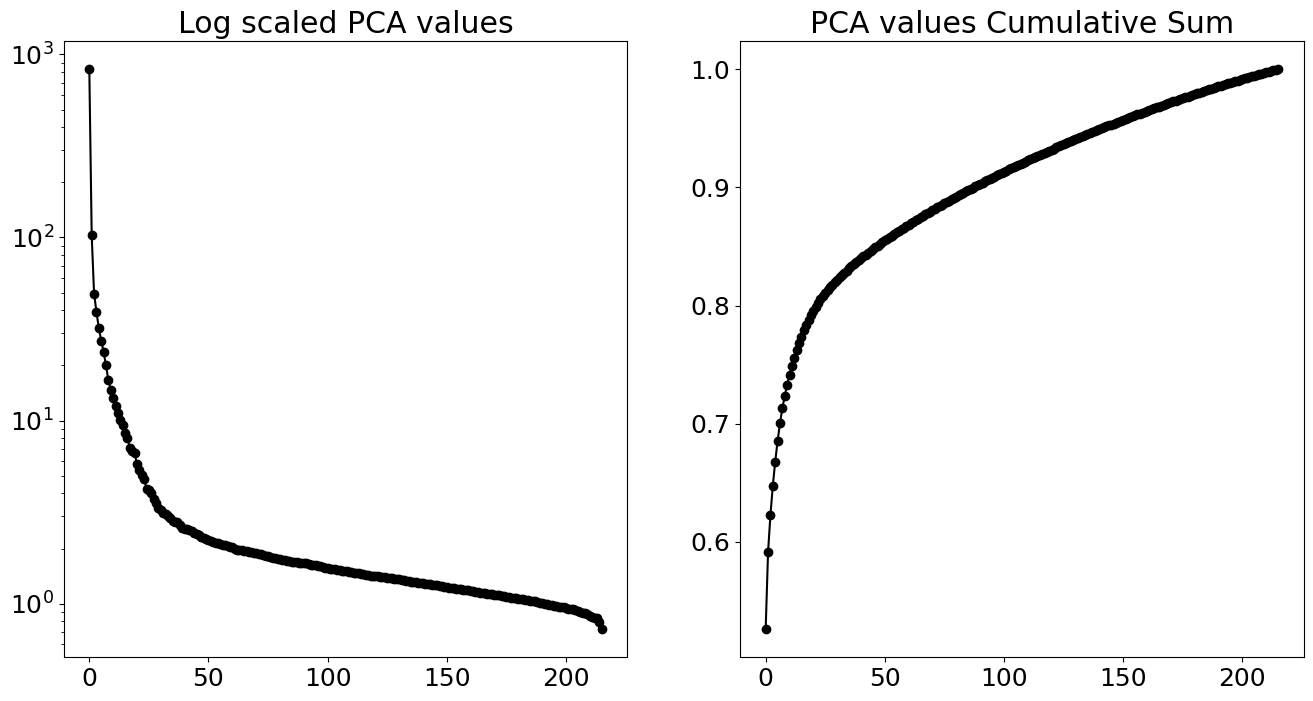

In [21]:
data = np.loadtxt(os.path.join('ovariancancer_obs.csv'),delimiter=',')  #Loading data

f = open(os.path.join('ovariancancer_grp.csv'), "r")
target = f.read().split("\n")
target.pop(-1)
data = np.array(data)
target = np.array(target)

U, S, VT = np.linalg.svd(data,full_matrices=0)        # Performing PCA

fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
ax1.semilogy(S,'-o',color='k') # PCA values log plot
ax1.set_title('Log scaled PCA values')
ax2 = fig1.add_subplot(122)
ax2.plot(np.cumsum(S)/np.sum(S),'-o',color='k') #PCA values cumulative sum plot
ax2.set_title('PCA values Cumulative Sum')
plt.savefig('PCA')
plt.show()

The graph on the right shows us that by resticting ourselves to 3 PCA dimension, we conserve more than 60% of the total variance. 

Now we plot the data transformed to the 3D PCA space.

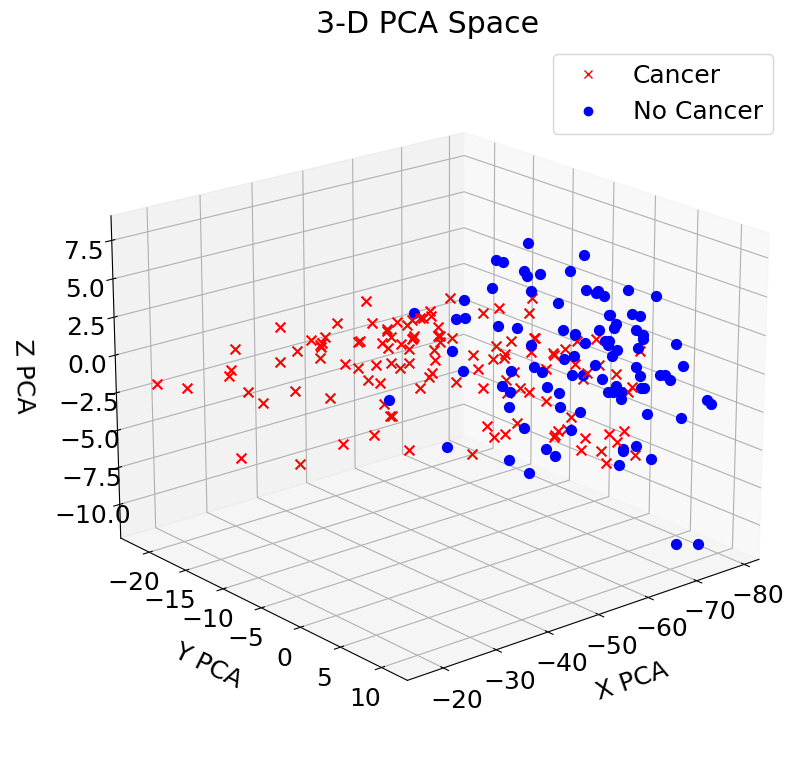

In [22]:
fig2 = plt.figure(figsize=(16,8))
ax = fig2.add_subplot(111, projection='3d')

for j in range(data.shape[0]):
    x = VT[0,:] @ data[j,:].T
    y = VT[1,:] @ data[j,:].T
    z = VT[2,:] @ data[j,:].T
    
    if target[j] == 'Cancer':
        ax.scatter(x,y,z,marker='x',color='r',s=50)
    else:
        ax.scatter(x,y,z,marker='o',color='b',s=50)

# ax.scatter(0,0,0, alpha= 1 ,marker='o',color='b',s=1, label = 'No Cancer')
# ax.scatter(0,0,0, alpha= 1 ,marker='x',color='r',s=1, label = 'Cancer')

# u  = Line2D([0],[0], marker='.', label = 'No Cancer')

legend_elements = [Line2D([0], [0], color='red', marker = 'x', ls ='', label='Cancer'),
                   Line2D([0], [0], color='blue', marker = 'o', ls= '', label='No Cancer'),]


ax.set_xlabel('X PCA', labelpad = 15)
ax.set_ylabel('Y PCA', labelpad = 15)
ax.set_zlabel('Z PCA', labelpad = 18)

ax.set_title('3-D PCA Space')
ax.legend(handles=legend_elements, loc='upper right')



ax.view_init(20,50)
plt.tight_layout()
plt.savefig('3DPCAscat')
plt.show()

We can see that the points appear to cluster into two groups. This shows us that ovarian cancer is highly correlated to these genetic markers. We can now apply a classification model and observe the results.

First, we give numeric values to our tagerts.

In [23]:
target = preprocessing.LabelEncoder().fit_transform(y= target) # 1 = Cancer, 0 = No Cancer

We could also normalize our data (See Appendix). However, we will not do this because it doesn't seem to change our model significantly.

In [24]:
# sc = StandardScaler()
# sc.fit(data)
# data = sc.transform(data)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, stratify=target)  #split test and training 

svm = SVC(kernel='linear', C=10)  #First we will use a SVM model
svm.fit(X_train, y_train)
predictions = svm.predict(X_test)

Which metric should we use to evaluate our mode? Before answering, let's take a look at the confusion matrix:

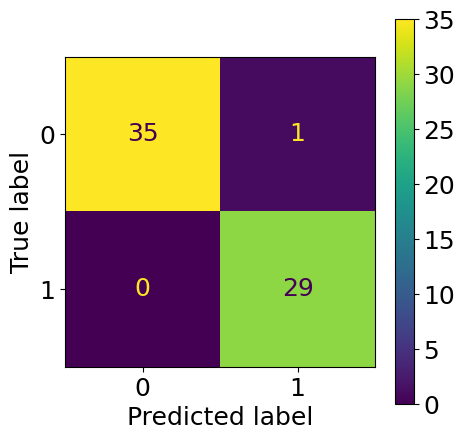

In [29]:
cm = confusion_matrix(y_test, predictions)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax);
plt.savefig('confusion')

We see that our model had 0 False Negatives, and 2 False Positives. Since we are talking about cancer patients, it is not so serious to predict False Postives, this would only result in more tests. On the other hand, False Negatives could potentially kill the patient. A good way to measure the effectiveness of a classifier in not predicting False Negatives is the Recall Score. The Recall Score for our model has to be as close to 1 as possible: 

In [8]:
print(f'Model recall score = {recall_score(y_test,predictions)}')

Model recall score = 1.0


So it seems that a SVM model is perfect for our ploblem.

Now, to better visualize what the model is doing, we will plot the decision boundaries. For that we will define 2 functions, one for plotting in the 2D PCA space, and the other for the 3D PCA space. The idea is to define a grid in 2D/3D PCA Space, transform the grid to the full space, predict the labels, and then apply those labels to the correspondent points in 2D/3D. Since we are going from a 2D/3D space to a 4000D space, some coordinates of the points are arbitrary, and this means that this method will only give us an approximation. The best method would be to simply produce a grid in the 4000D space, but this would require more memory than my computer currently has. 

In [14]:
def plot_decision_regions_2dPCA(data, classifier = svm,
 resolution=1):

   # define grid in PCA space

   data_pca = VT[:2,:]@data.T  

   xpca = data_pca[0,:]
   ypca = data_pca[1,:]
#  zpca = data_pca[2,:]

   xx = np.linspace(xpca.min() - 1, xpca.max() + 1, 100*resolution)
   yy = np.linspace(ypca.min() - 1, ypca.max() + 1, 100*resolution)
#  zz = np.linspace(zpca.min() - 1, zpca.max() + 1, 10)

   xgrid, ygrid = np.meshgrid(xx,yy, indexing = 'xy')

   points_grid = np.vstack([xgrid.flatten(),ygrid.flatten()])

   # transform grid to original space

   T = (np.linalg.pinv(VT[:2,:])@points_grid).T

   # predict grid points

   pred_grid = classifier.predict(T)

   # plot decision regions

   fig = go.Figure()

   fig.add_contour(x = xgrid.flatten(), y = ygrid.flatten(), z = pred_grid, opacity = 0.2, colorscale = ['blue','red'], colorbar=dict(
            thickness=25,
            thicknessmode='pixels',
            len=0.8,
            lenmode='fraction',
            outlinewidth=0, nticks=1, y = 0.4))

   # plot data points

   for j in range(data.shape[0]):
    x = VT[0,:] @ data[j,:].T
    y = VT[1,:] @ data[j,:].T
  # z = VT[2,:] @ data[j,:].T
    
    if target[j] == 1:
        fig.add_scatter(x = [x],y = [y], mode='markers', marker=dict(
        size=5,
        symbol='x',
        color='red',                # set color to an array/list of desired values
        opacity=0.6), showlegend=False)

    else:
        fig.add_scatter(x= [x],y = [y], mode = 'markers', marker=dict(
        size=5,
        symbol ='circle',
        color='blue',                # set color to an array/list of desired values
        opacity=0.6), 
        showlegend=False)

   fig.add_scatter(x = ['None'], y = ['None'], mode = 'markers', name = 'Cancer',marker=dict(
      size=7,
      symbol ='x',
      color='red'))  # Labels

   fig.add_scatter(x = ['None'], y = ['None'], mode = 'markers', name = 'No Cancer',marker=dict(
      size=7,
      symbol ='circle',
      color='blue')) # Labels

   fig.update_layout(legend=dict(
      yanchor="top",
      y=1,
      xanchor="left",
      x=1.01
   )) ## Labels

   fig.update_xaxes(title = 'X PCA')
   fig.update_yaxes(title = 'Y PCA')
   fig.update_layout(title = '2-D PCA Decision Boundary', title_x = 0.47)
   
   fig.show()

   fig.write_html('2dpca.html')


In [15]:
plot_decision_regions_2dPCA(data)

In [16]:
def plot_decision_regions_3dPCA(data, classifier = svm, resolution=1):

   # define grid in PCA space

   data_pca = VT[:3,:]@data.T  

   xpca = data_pca[0,:]
   ypca = data_pca[1,:]
   zpca = data_pca[2,:]

   xx = np.linspace(xpca.min() - 1, xpca.max() + 1, 10*resolution)
   yy = np.linspace(ypca.min() - 1, ypca.max() + 1, 10*resolution)
   zz = np.linspace(zpca.min() - 1, zpca.max() + 1, 10*resolution)

   xgrid, ygrid, zgrid = np.meshgrid(xx,yy,zz, indexing = 'xy')

   points_grid = np.vstack([xgrid.flatten(),ygrid.flatten(),zgrid.flatten()])

   # transform grid to original space

   T = (np.linalg.pinv(VT[:3,:])@points_grid).T

   # predict grid points

   pred_grid = classifier.predict(T)

   # plot decision regions

   fig = go.Figure()

   fig.add_volume(x = xgrid.flatten(), y = ygrid.flatten(), z = zgrid.flatten(), value = pred_grid, colorscale = ['red','blue'], opacity = 0.15,)

   # plot data points

   for j in range(data.shape[0]):
    x = VT[0,:] @ data[j,:].T
    y = VT[1,:] @ data[j,:].T
    z = VT[2,:] @ data[j,:].T
    
    if target[j] == 1:
        fig.add_scatter3d(x = [x],y = [y],z = [z], showlegend = False, marker=dict(
        size=5,
        color='blue',                # set color to an array/list of desired values
        opacity=0.5,
        ))

    else:
        fig.add_scatter3d(x= [x],y = [y],z = [z], showlegend = False, marker=dict(
        size=5,
        color='red',                # set color to an array/list of desired values
        opacity=0.5,
        ))

   fig.add_scatter3d(x = ['None'], y = ['None'], z = ['None'], mode = 'markers', name = 'Cancer', marker=dict(
      size=7,
      symbol ='x',
      color='red'))

   fig.add_scatter3d(x = ['None'], y = ['None'], z = ['None'],  mode = 'markers', name = 'No Cancer', marker=dict(
      size=7,
      symbol ='circle',
      color='blue'))
   
   fig.update_layout(legend=dict(
      yanchor="top",
      y=1,
      xanchor="left",
      x=0.01
   ))

   fig.update_layout(title = '3-D PCA Decision Boundary', title_x = 0.47, scene = dict(
                    xaxis_title='X PCA',
                    yaxis_title='Y PCA',
                    zaxis_title='Z PCA'),)

   fig.show()

   fig.write_html('3dpca.html')

In [17]:
plot_decision_regions_3dPCA(data)

Appendix: 

For the sake of Machine Learning, we will see how other famous models behave on this dataset.

In [18]:
sc = StandardScaler()
sc.fit(data)
data = sc.transform(data)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, stratify=target)  #split test and training 


In [19]:
logi = LogisticRegression(C=10,  multi_class='ovr')
logi.fit(X_train, y_train)

print(f'Logistic regression Recall:{recall_score(y_test, logi.predict(X_test))}')

forest = RandomForestClassifier(n_estimators=100, n_jobs=2)
forest.fit(X_train, y_train)

print(f'Random Forest Recall:{recall_score(y_test, forest.predict(X_test))}')


recall_score(y_test, forest.predict(X_test))
tree_model =  DecisionTreeClassifier(criterion='gini', max_depth=5)
tree_model.fit(X_train, y_train)

print(f'Decision Tree Recall:{recall_score(y_test, tree_model.predict(X_test))}')

Logistic regression Recall:1.0
Random Forest Recall:0.9310344827586207
Decision Tree Recall:0.896551724137931


A good advantage of the Logistic Regression Model for heath care predictions like this one is that it can also give us the probabilities of the predictions.

In [34]:
probabilities = logi.predict_proba(X_test)

We can plot the Decision Tree for the Tree Model:

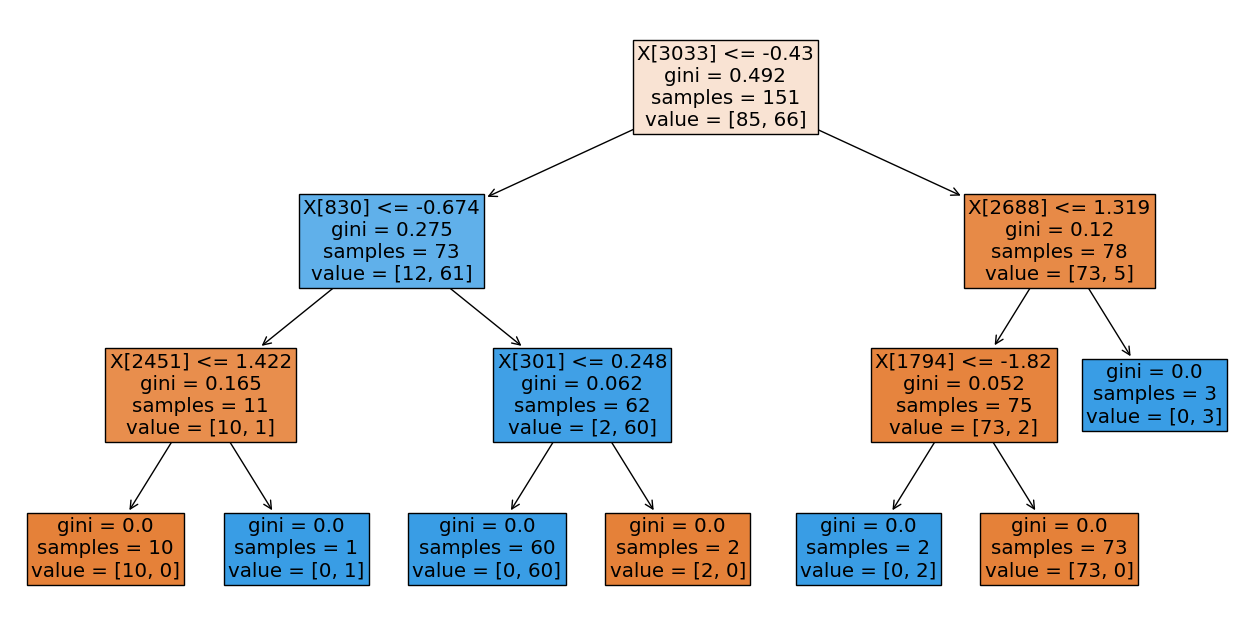

In [20]:
tree.plot_tree(tree_model,
filled=True)
plt.show()